# Import Graph

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install spektral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 4.2 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd

# Set the environment variable before importing TensorFlow and TensorFlow GNN
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow as tf
import networkx as nx

from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Normalization
from sklearn.preprocessing import StandardScaler
from spektral.data.graph import Graph
from spektral.data import SingleLoader, Dataset
from scipy.sparse import coo_matrix
from spektral.layers import MessagePassing, EdgeConv, GraphMasking
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate


#  Import networkX graph from file
G = nx.read_graphml('graph.graphml')


# Target labels
edge_labels = np.array([0 if attrs["fraud_proportion"] == 0 else 1 for _, _, attrs in G.edges(data=True)])
labels = np.array([0 if attrs["is_fraud"] == 0 else 1 for _, attrs in G.nodes(data=True)])

print("Edge labels shape: ", edge_labels.shape)
print("Node labels shape: ", labels.shape)

Edge labels shape:  (12434,)
Node labels shape:  (8292,)


# Spliting Validation / Training (not being used)

In [4]:
# Split masking

# Assuming single graph with N nodes and their labels
N = labels.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)

# Define split ratios
train_size = int(0.8 * N)
train_indices, val_indices = indices[:train_size], indices[train_size:]

# Create masks
train_mask = np.zeros(N, dtype=bool)
val_mask = np.zeros(N, dtype=bool)
train_mask[train_indices] = True
val_mask[val_indices] = True


# Adjency Matrix (1st parameter)

In [5]:
# Extract node indices
node_list = list(G.nodes)
node_indices = {node: idx for idx, node in enumerate(node_list)}

# Calculate edge weights
max_transactions = max([attrs["total_transactions"] for _, _, attrs in G.edges(data=True)])
min_transactions = min([attrs["total_transactions"] for _, _, attrs in G.edges(data=True)])

print("Max transactions: ", max_transactions)
print("Min transactions: ", min_transactions)

# Max min regulzarization
for u, v, attrs in G.edges(data=True):
    attrs["weight"] = (attrs["total_transactions"] - min_transactions) / (max_transactions - min_transactions)


# Extract edge indices using the node indices
edge_indices = np.array([(node_indices[u], node_indices[v]) for u, v, attrs in G.edges(data=True)])
edge_weights = np.array([attrs["weight"] for _, _, attrs in G.edges(data=True)])


# Create Adjency matrix
adjency_matrix_coo_df = pd.DataFrame([], columns=["source", "target", "weight", "label"])
for ix, edge in enumerate(edge_indices):
    adjency_matrix_coo_df.loc[len(adjency_matrix_coo_df)] = [
        int(edge[0]),
        int(edge[1]),
        edge_weights[ix],
        int(edge_labels[ix])
    ]
adjency_matrix_coo_df.head()


Max transactions:  181
Min transactions:  1


,source,target,weight,label
0,0.0,1.0,0.100000,0.0
1,1.0,2133.0,0.994444,0.0
2,2.0,3.0,0.122222,0.0
3,3.0,2031.0,0.994444,0.0
4,4.0,5.0,0.077778,0.0


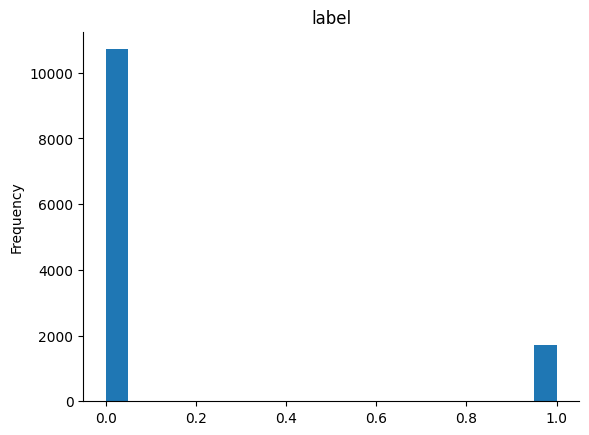

In [6]:
# @title label

from matplotlib import pyplot as plt
adjency_matrix_coo_df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Node Features (2nd parameter)

In [7]:
country_vocab = set()
account_type_vocab = set()
customer_id_vocab = set()

for n, attrs in G.nodes(data=True):

    # Preprocess the customer ID
    attrs["customer_id"] = attrs.get("customer_id").replace("_", "")

    country_vocab.add(attrs.get("country", "unknown"))
    account_type_vocab.add(attrs.get("type", "unknown"))
    customer_id_vocab.add(attrs.get("customer_id"))

print(f"Country vocab size: {len(country_vocab)}")
print(f"Type vocab size: {len(account_type_vocab)}")
print(f"Customer ID vocab size: {len(customer_id_vocab)}")


# Define a TensorFlow encoder
class NodeAttributeEncoder(tf.keras.layers.Layer):
    def __init__(
        self, country_vocab_size, type_vocab_size, customer_id_vocab_size, output_dim
    ):
        super(NodeAttributeEncoder, self).__init__()
        self.country_embedding = tf.keras.layers.Embedding(
            country_vocab_size, output_dim
        )
        self.account_type_embedding = tf.keras.layers.Embedding(
            type_vocab_size, output_dim
        )
        self.customer_id_normalizer = tf.keras.layers.Embedding(
            customer_id_vocab_size, output_dim
        )

        # Initialize tokenizers
        self.country_tokenizer = Tokenizer(
            num_words=country_vocab_size, oov_token="<OOV>", split=" "
        )
        self.type_tokenizer = Tokenizer(num_words=type_vocab_size, oov_token="<OOV>", split=" ")
        self.customer_id_tokenizer = Tokenizer(
            num_words=customer_id_vocab_size, oov_token="<OOV>", split=" "
        )

    def fit_tokenizers(self, country_texts, type_texts, customer_id_texts):
        # Fit tokenizers on the respective input data
        self.country_tokenizer.fit_on_texts(country_texts)
        self.type_tokenizer.fit_on_texts(type_texts)
        self.customer_id_tokenizer.fit_on_texts(customer_id_texts)

    def call(self, inputs):
        country, customer_id, account_type_, is_fraud = inputs

        # Convert text to sequences of integers
        country_seq = self.country_tokenizer.texts_to_sequences([country])
        type_seq = self.type_tokenizer.texts_to_sequences([account_type_])
        customer_id_seq = self.customer_id_tokenizer.texts_to_sequences([customer_id])

        # Convert sequences to tensors
        country_seq = tf.constant(country_seq)
        type_seq = tf.constant(type_seq)
        customer_id_seq = tf.constant(customer_id_seq)

        # Pad sequences to ensure uniform length
        country_seq = tf.keras.preprocessing.sequence.pad_sequences(
            country_seq, padding="post"
        )
        type_seq = tf.keras.preprocessing.sequence.pad_sequences(
            type_seq, padding="post"
        )
        customer_id_seq = tf.keras.preprocessing.sequence.pad_sequences(
            customer_id_seq, padding="post"
        )

        # Embed the sequences
        country_encoded = self.country_embedding(country_seq)
        type_encoded = self.account_type_embedding(type_seq)
        customer_id_encoded = self.customer_id_normalizer(customer_id_seq)


        # Embed is_fraud
        is_fraud_tf= tf.reshape(tf.cast(is_fraud, tf.float32), [1,1,1])
        return tf.concat([country_encoded, customer_id_encoded, type_encoded, is_fraud_tf], axis=-1)


node_encoder = NodeAttributeEncoder(
    len(country_vocab) + 1,
    len(account_type_vocab) + 1,
    len(customer_id_vocab) + 1,
    output_dim=1,
)
node_encoder.fit_tokenizers(
    list(country_vocab), list(account_type_vocab), list(customer_id_vocab)
)

# Encode node attributes to feature vectors
node_features = tf.TensorArray(tf.float32, size=G.number_of_nodes())
for index, node_obj in enumerate(G.nodes(data=True)):
    node, attrs = node_obj
    encoded_features = node_encoder.call(
        (
            attrs.get("country", "unknown"),
            attrs.get("customer_id", "unknown"),
            attrs.get("type", "unknown"),
            0 if not attrs.get("is_fraud") else 1
        )
    )
    node_features = node_features.write(index, tf.squeeze(encoded_features, axis=0))

# Convert TensorArray to Tensor
node_features_tf = node_features.stack()
node_features_tf = tf.reshape(node_features_tf, (G.number_of_nodes(), 4))
print(node_features_tf.shape)

Country vocab size: 1
Type vocab size: 1
Customer ID vocab size: 8292
(8292, 4)


# Edge Features (3rd parameter)

In [8]:
# Sample data
total_amount_vec = [attrs.get("total_amount") for a, b, attrs in G.edges(data=True)]

# Convert to NumPy array and reshape
total_amount_vec = np.array(total_amount_vec).reshape(-1, 1)

# Check for NaN or infinite values
if np.any(np.isnan(total_amount_vec)) or np.any(np.isinf(total_amount_vec)):
    raise ValueError("Data contains NaN or infinite values")

# Alternative normalization using StandardScaler
scaler = StandardScaler()

scaler.fit(total_amount_vec)
total_amount_normalized = scaler.transform(total_amount_vec)


total_transactions_vec = np.array(
    [attrs.get("total_transactions") for a, b, attrs in G.edges(data=True)]
).reshape(-1, 1)
scaler.fit(total_transactions_vec)
total_transactions_normalized = scaler.transform(total_transactions_vec)

fraud_proportion_vec = np.array(
    [attrs.get("fraud_proportion") for a, b, attrs in G.edges(data=True)]
).reshape(-1, 1)
scaler.fit(fraud_proportion_vec)
fraud_proportion_normalized = scaler.transform(fraud_proportion_vec)


edge_features = tf.concat(
    [
        total_amount_normalized,
        total_transactions_normalized,
        fraud_proportion_normalized,
    ],
    axis=-1,
)

print(edge_features.shape)

(12434, 3)


# Create GNN

In [9]:
# Create a GraphTensor
num_nodes = len(G.nodes)

source_nodes = adjency_matrix_coo_df["source"].apply(lambda x: int(x)).values
target_nodes = adjency_matrix_coo_df["target"].apply(lambda x: int(x)).values
weights = adjency_matrix_coo_df["weight"].values

a = coo_matrix(
    (weights, (source_nodes, target_nodes)),
    shape=(num_nodes, num_nodes),
)
x = node_features_tf.numpy()  # node features
e = edge_features.numpy()  # edge features

y = labels  # edge labels

print("Node features shape: ", x.shape)
print("Node labels shape: ", y.shape)
print("Edge features shape: ", e.shape)

graph = Graph(x=x, a=a, e=e, y=y, train_mask=train_mask, val_mask=val_mask)

# Create a custom dataset class
class SingleGraphDataset(Dataset):
    def __init__(self, graph, **kwargs):
        self.graph = graph
        super().__init__(**kwargs)

    def read(self):
        return [self.graph]

dataset = SingleGraphDataset(graph)
loader = SingleLoader(dataset=dataset)

Node features shape:  (8292, 4)
Node labels shape:  (8292,)
Edge features shape:  (12434, 3)


In [10]:
# Define the GCN model
class EdgeNodeGCN(Model):
    def __init__(self):
        super().__init__()
        # Masking
        # self.masking = GraphMasking()


        # Node Convolution part using MessagePassing
        self.node_conv = MessagePassing(aggregate='sum')
        self.node_dense = Dense(256, activation='relu')

        # Edge Convolution part
        self.edge_conv = EdgeConv(256, activation='relu')
        self.edge_dense = Dense(128, activation='relu')

        # Combine node and edge features
        self.concat = Concatenate()

        # Final output layer
        self.final_dense1 = Dense(32, activation='relu')
        self.final_dense2 = Dense(1, activation='sigmoid')

    def call(self, inputs):
        x, a, e = inputs

        # Masking
        # x = self.masking(x)

        # Node convolution
        convoluted_nodes = self.node_conv([x, a, e])  # Apply message passing
        convoluted_nodes = self.node_dense(convoluted_nodes)

        # Edge convolution
        convoluted_edges = self.edge_conv([x, a, e])
        convoluted_edges = self.edge_dense(convoluted_edges)

        # Combine node and edge features
        combined_features = self.concat([convoluted_nodes, convoluted_edges])

        # Final prediction
        out = self.final_dense1(combined_features)
        out = self.final_dense2(out)

        return out



# Model Training

Epoch 1/250
1/1 [==============================] - 7s 7s/step - loss: 0.7741 - accuracy: 0.3150
Epoch 2/250
1/1 [==============================] - 0s 140ms/step - loss: 0.7739 - accuracy: 0.3151
Epoch 3/250
1/1 [==============================] - 0s 189ms/step - loss: 0.7736 - accuracy: 0.3152
Epoch 4/250
1/1 [==============================] - 0s 178ms/step - loss: 0.7733 - accuracy: 0.3155
Epoch 5/250
1/1 [==============================] - 0s 207ms/step - loss: 0.7731 - accuracy: 0.3158
Epoch 6/250
1/1 [==============================] - 0s 227ms/step - loss: 0.7728 - accuracy: 0.3166
Epoch 7/250
1/1 [==============================] - 0s 284ms/step - loss: 0.7725 - accuracy: 0.3172
Epoch 8/250
1/1 [==============================] - 0s 188ms/step - loss: 0.7723 - accuracy: 0.3172
Epoch 9/250
1/1 [==============================] - 0s 139ms/step - loss: 0.7720 - accuracy: 0.3174
Epoch 10/250
1/1 [==============================] - 0s 283ms/step - loss: 0.7718 - accuracy: 0.3178
Epoch 11/250

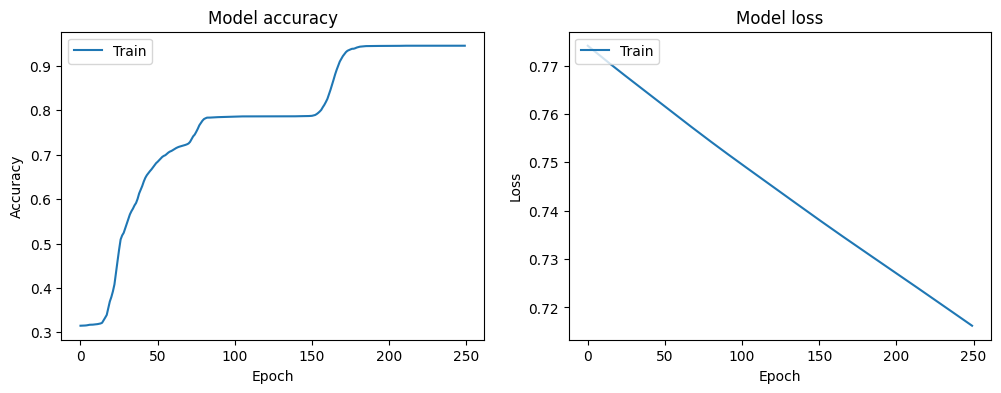

1/1 [==============================] - 0s 159ms/step
[[0.4932573 ]
 [0.4835435 ]
 [0.4932573 ]
 ...
 [0.49062368]
 [0.48597834]
 [0.48599213]]


In [11]:

tf.debugging.set_log_device_placement(True)

# Create the model
model = EdgeNodeGCN()
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
class_weights = {0: 1.0, 1: 1.5}
history = model.fit(loader.load(), epochs=250, steps_per_epoch=loader.steps_per_epoch, class_weight=class_weights)

# Plot the training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.show()

# Predict the fraud proportion
y_pred = model.predict(loader.load(), steps=loader.steps_per_epoch)
print(y_pred)


(8292,)
(8292, 1)


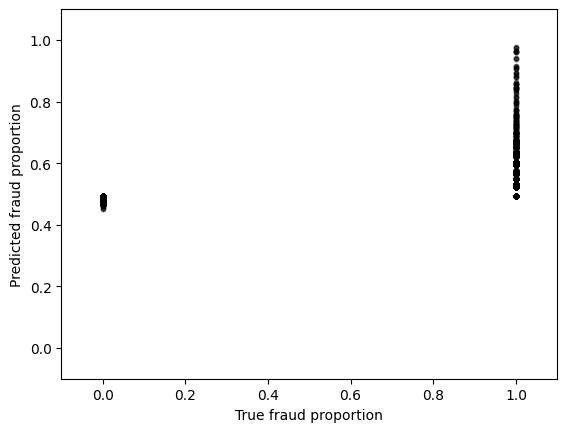

In [12]:
from scipy.stats import gaussian_kde

print(y.shape)
print(y_pred.shape)

plt.xlabel('True fraud proportion')
plt.ylabel('Predicted fraud proportion')

plt.scatter(y, y_pred, c='black', s=10, alpha=0.5)  # Add scatter points on top

# Set axis limit
plt.ylim(-0.1, 1.1)
plt.xlim(-0.1, 1.1)

plt.show()

# Export Model

In [13]:
model.save('ffd_gnn', save_format='tf')